In [1]:
import os
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv
from google.cloud import bigquery
from google.oauth2 import service_account

import matplotlib.pyplot as plt

load_dotenv()

_GCP_PROJECT_ID = os.getenv('GCP_PROJECT_ID')
_BQ_DATASET_MARTS = os.getenv('BIGQUERY_DATASET_MARTS')

In [2]:
try:
    creds = service_account.Credentials.from_service_account_info(
        st.secrets['gcp_service_account']
    )
    client = bigquery.Client(credentials=creds, project=creds.project_id)
except Exception:
    # Local dev fallback (requires GOOGLE_APPLICATION_CREDENTIALS)
    client = bigquery.Client()

In [3]:
# Get activities
query_activities = f"SELECT * FROM {_GCP_PROJECT_ID}.{_BQ_DATASET_MARTS}.fct_activities"
df_activities = client.query(query_activities).to_dataframe()

print(f'Count activities: {len(df_activities)}')

Count activities: 406


In [4]:
df_runs = df_activities[df_activities['discipline'] == 'Run'].copy()
print(f'Len relevant activities: {len(df_runs)}')

Len relevant activities: 243


In [5]:
df = df_runs.copy()

# Required columns check
req = ["start_date_local", "distance_km", "moving_time_s"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["start_date_local"] = pd.to_datetime(df["start_date_local"])
df = df.sort_values("start_date_local").reset_index(drop=True)

# Compute pace_sec_per_km if missing
if "pace_sec_per_km" not in df.columns:
    df["pace_sec_per_km"] = df["moving_time_s"] / df["distance_km"]

# Basic sanity filtering (tune)
df = df[(df["distance_km"] > 0) & (df["moving_time_s"] > 0)].copy()
df = df[(df["pace_sec_per_km"] >= 120) & (df["pace_sec_per_km"] <= 900)].copy()

df.head()

,activity_id,athlete_id,gear_id,activity_name,discipline,start_date_local,activity_date_local,activity_year,activity_month,activity_weekday,...,comment_count,achievement_count,is_race,is_commute,is_trainer,has_heartrate,map_id,map_polyline,mart_loaded_at,pace_sec_per_km
0,12635874694,133094316,g20984891,Lunch Run,Run,2024-10-12 12:39:59+00:00,2024-10-12,2024,10,7,...,0,0,False,False,False,False,a12635874694,geluHuk|j@BvBIbEYjCI`BOzAGZg@dAOl@i@xAKb@]bCIx...,2026-01-29 19:58:01.800484+00:00,277.990734
1,12644836289,133094316,g20984891,Recovery Run,Run,2024-10-13 12:59:52+00:00,2024-10-13,2024,10,1,...,0,0,False,False,False,False,a12644836289,geluHsl|j@D~@AdCUhESxAObCQfASv@a@lAc@z@Mj@Mr@G...,2026-01-29 19:58:01.800484+00:00,334.738637
2,12692532615,133094316,g20984891,Saturday Run,Run,2024-10-19 14:00:00+00:00,2024-10-19,2024,10,7,...,0,0,False,False,False,True,a12692532615,_eluHcn|j@HpEC~@SfCYlBKnA_@xBa@dB_A~Be@bBMr@Op...,2026-01-29 19:58:01.800484+00:00,280.734901
3,12748074315,133094316,g20984891,Saturday Run,Run,2024-10-26 13:10:20+00:00,2024-10-26,2024,10,7,...,0,0,False,False,False,True,a12748074315,aeluHek|j@BVCj@@nCOdBKj@Ej@Ax@EpA?h@CZKd@c@jAO...,2026-01-29 19:58:01.800484+00:00,323.190737
4,12756520680,133094316,g20984905,Relaxed Sunday Run,Run,2024-10-27 11:46:53+00:00,2024-10-27,2024,10,1,...,0,0,False,False,False,True,a12756520680,meluHim|j@?lAPnACrBIx@c@hDO`DEZGZi@bAmA~DWlAOn...,2026-01-29 19:58:01.800484+00:00,341.373834


In [ ]:
import numpy as np
df["date"] = df["start_date_local"].dt.date

# Time-weighted pace: total_time / total_distance
daily = (
    df.groupby("date", as_index=False)
      .agg(
          runs=("distance_km", "size"),
          distance_km=("distance_km", "sum"),
          time_s=("moving_time_s", "sum"),
          elev_gain_m=("elevation_gain_m", "sum") if "elevation_gain_m" in df.columns else ("moving_time_s", "sum"),
          hr_time_weighted=("avg_heartrate", lambda x: np.nan)  # placeholder, set below if HR exists
      )
)

daily["pace_sec_per_km"] = daily["time_s"] / daily["distance_km"]

# HR time-weighted mean (only if available)
if "avg_heartrate" in df.columns:
    if "has_heartrate" in df.columns:
        dhr = df[df["has_heartrate"].fillna(False)].copy()
    else:
        dhr = df[df["avg_heartrate"].notna()].copy()

    if len(dhr) > 0:
        dhr["date"] = dhr["start_date_local"].dt.date
        hr_daily = (
            dhr.groupby("date", as_index=False)
               .apply(lambda g: pd.Series({
                   "hr_mean": np.sum(g["avg_heartrate"] * g["moving_time_s"]) / np.sum(g["moving_time_s"])
               }))
               .reset_index(drop=True)
        )
        daily = daily.merge(hr_daily, on="date", how="left")
    else:
        daily["hr_mean"] = np.nan
else:
    daily["hr_mean"] = np.nan

daily.head()

C:\Users\xaver\AppData\Local\Temp\ipykernel_4616\599984567.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,date,runs,distance_km,time_s,elev_gain_m,hr_time_weighted,pace_sec_per_km,hr_mean
0,2024-10-12,1,6.0002,1668,41.4,NaN,277.990734,NaN
1,2024-10-13,1,8.6814,2906,72.3,NaN,334.738637,NaN
2,2024-10-19,1,15.3490,4309,97.8,NaN,280.734901,171.7
3,2024-10-26,1,7.7725,2512,61.9,NaN,323.190737,156.9
4,2024-10-27,1,10.0740,3439,78.4,NaN,341.373834,149.8


In [12]:
daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values("date").reset_index(drop=True)

full_dates = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
daily = daily.set_index("date").reindex(full_dates).rename_axis("date").reset_index()

# Fill "no training day" with zeros where appropriate
daily["runs"] = daily["runs"].fillna(0).astype(int)
daily["distance_km"] = daily["distance_km"].fillna(0.0)
daily["time_s"] = daily["time_s"].fillna(0.0)
if "elev_gain_m" in daily.columns:
    daily["elev_gain_m"] = daily["elev_gain_m"].fillna(0.0)

# pace & hr are undefined on rest days
daily.loc[daily["distance_km"] == 0, "pace_sec_per_km"] = np.nan
daily.loc[daily["distance_km"] == 0, "hr_mean"] = np.nan

daily.tail()


,date,runs,distance_km,time_s,elev_gain_m,hr_time_weighted,pace_sec_per_km,hr_mean
469,2026-01-24,0,0.0000,0,0.0,NaN,<NA>,NaN
470,2026-01-25,1,10.0039,2422,32.0,NaN,242.105579,177.5
471,2026-01-26,1,7.0182,2381,0.0,NaN,339.260779,119.5
472,2026-01-27,0,0.0000,0,0.0,NaN,<NA>,NaN
473,2026-01-28,1,12.7783,3762,78.0,NaN,294.405359,155.0


In [14]:
base_pace = daily["pace_sec_per_km"].median(skipna=True)  # sec/km
# intensity > 1 when faster than base pace
daily["intensity"] = np.where(
    daily["pace_sec_per_km"].notna(),
    base_pace / daily["pace_sec_per_km"],
    0.0
)
daily["load"] = (daily["time_s"] / 3600.0) * daily["intensity"]  # "effective hours"
daily.head()

,date,runs,distance_km,time_s,elev_gain_m,hr_time_weighted,pace_sec_per_km,hr_mean,intensity,load
0,2024-10-12,1,6.0002,1668,41.4,NaN,277.990734,NaN,1.102150,0.510663
1,2024-10-13,1,8.6814,2906,72.3,NaN,334.738637,NaN,0.915304,0.738853
2,2024-10-14,0,0.0000,0,0.0,NaN,<NA>,NaN,0.000000,0.0
3,2024-10-15,0,0.0000,0,0.0,NaN,<NA>,NaN,0.000000,0.0
4,2024-10-16,0,0.0000,0,0.0,NaN,<NA>,NaN,0.000000,0.0


In [15]:
def ewma_load(load: pd.Series, tau_days: float) -> pd.Series:
    # EWMA with decay constant tau
    alpha = 1 - np.exp(-1 / tau_days)
    return load.ewm(alpha=alpha, adjust=False).mean()

# Tuneable time constants (sport science defaults)
TAU_FITNESS = 42
TAU_FATIGUE = 7

daily["fitness"] = ewma_load(daily["load"], TAU_FITNESS)
daily["fatigue"] = ewma_load(daily["load"], TAU_FATIGUE)
daily["readiness"] = daily["fitness"] - daily["fatigue"]

daily[["date","load","fitness","fatigue","readiness"]].tail(10)


,date,load,fitness,fatigue,readiness
464,2026-01-19,0.0,0.534690,0.523024,0.011666
465,2026-01-20,0.68281,0.538175,0.544295,-0.006120
466,2026-01-21,0.858787,0.545718,0.586161,-0.040442
467,2026-01-22,0.0,0.532878,0.508130,0.024749
468,2026-01-23,0.544102,0.533143,0.512918,0.020224
469,2026-01-24,0.0,0.520599,0.444638,0.075961
470,2026-01-25,0.851408,0.528382,0.498788,0.029594
471,2026-01-26,0.597302,0.530004,0.511902,0.018101
472,2026-01-27,0.0,0.517533,0.443757,0.073777
473,2026-01-28,1.087531,0.530945,0.529457,0.001487


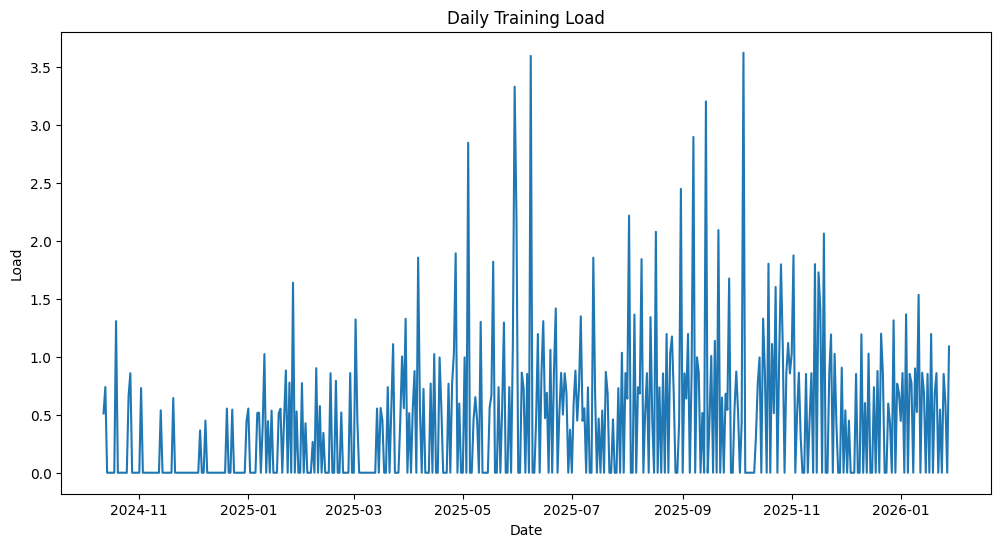

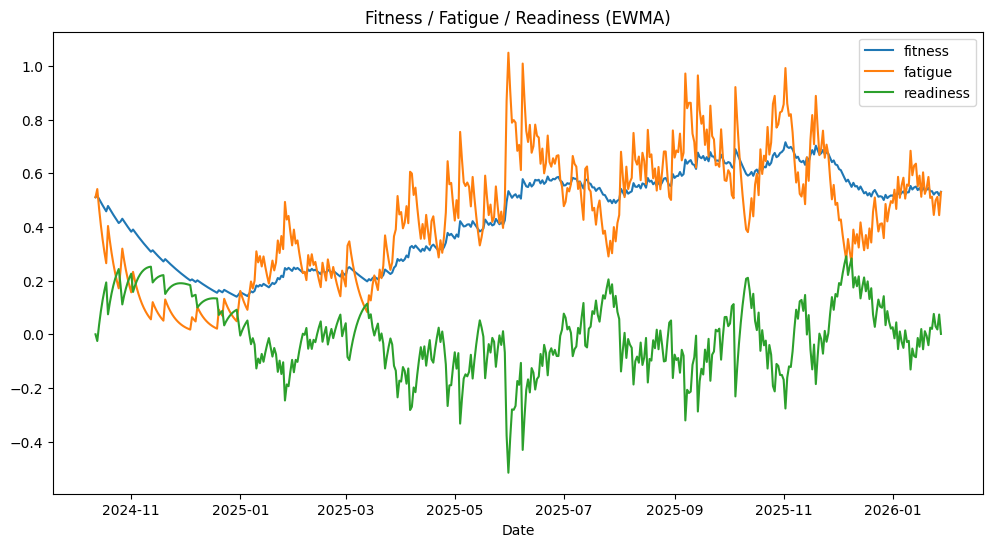

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(daily["date"], daily["load"])
plt.title("Daily Training Load")
plt.xlabel("Date")
plt.ylabel("Load")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(daily["date"], daily["fitness"], label="fitness")
plt.plot(daily["date"], daily["fatigue"], label="fatigue")
plt.plot(daily["date"], daily["readiness"], label="readiness")
plt.title("Fitness / Fatigue / Readiness (EWMA)")
plt.xlabel("Date")
plt.legend()
plt.show()


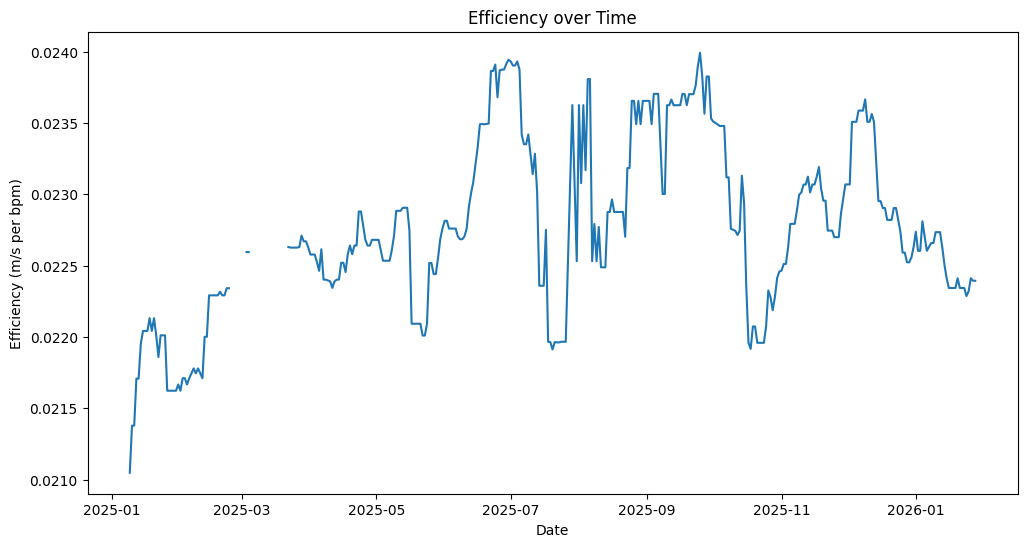

In [25]:
# speed in m/s from pace (sec/km): speed = 1000 / pace
daily["speed_mps"] = np.where(daily["pace_sec_per_km"].notna(), 1000.0 / daily["pace_sec_per_km"], np.nan)

# efficiency proxy: speed per bpm
daily["efficiency"] = np.where(
    (daily["speed_mps"].notna()) & (daily["hr_mean"].notna()) & (daily["hr_mean"] > 0),
    daily["speed_mps"] / daily["hr_mean"],
    np.nan
)

# Smooth it (observations are noisy)
daily["efficiency_smooth"] = daily["efficiency"].rolling(14, min_periods=5).median()

daily[["date","efficiency","efficiency_smooth"]].dropna().head()
plt.figure(figsize=(12,6))
plt.plot(daily["date"], daily["efficiency_smooth"], label="Efficiency (smoothed)")
plt.title("Efficiency over Time")
plt.xlabel("Date")
plt.ylabel("Efficiency (m/s per bpm)")
plt.show()


In [21]:
def score_taus(daily_df: pd.DataFrame, tau_fit: int, tau_fat: int) -> float:
    tmp = daily_df.copy()
    tmp["fitness"] = ewma_load(tmp["load"], tau_fit)
    tmp["fatigue"] = ewma_load(tmp["load"], tau_fat)
    tmp["readiness"] = tmp["fitness"] - tmp["fatigue"]

    # Fit a simple linear mapping from readiness to efficiency_smooth
    m = tmp.dropna(subset=["readiness","efficiency_smooth"])
    if len(m) < 30:
        return np.inf  # not enough HR days

    X = m["readiness"].values
    y = m["efficiency_smooth"].values

    # linear regression closed form
    Xc = X - X.mean()
    yc = y - y.mean()
    denom = np.sum(Xc**2)
    if denom == 0:
        return np.inf
    beta = np.sum(Xc * yc) / denom
    yhat = y.mean() + beta * (X - X.mean())

    # MAE
    return float(np.mean(np.abs(y - yhat)))

# Grid search (keep small)
fit_grid = range(21, 71, 7)   # fitness tau candidates
fat_grid = range(3, 15, 2)    # fatigue tau candidates

best = (None, None, np.inf)
for tf in fit_grid:
    for ta in fat_grid:
        if ta >= tf:
            continue
        s = score_taus(daily, tf, ta)
        if s < best[2]:
            best = (tf, ta, s)

best


(21, 7, 0.0004666276870535406)

In [22]:
TAU_FITNESS, TAU_FATIGUE = best[0], best[1]
daily["fitness"] = ewma_load(daily["load"], TAU_FITNESS)
daily["fatigue"] = ewma_load(daily["load"], TAU_FATIGUE)
daily["readiness"] = daily["fitness"] - daily["fatigue"]

print("Best taus:", TAU_FITNESS, TAU_FATIGUE)


Best taus: 21 7
